In [1]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
import os
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
# from keras.applications.resnet50 import ResNet50
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50
import pandas as pd
import tensorflow as tf



In [2]:
labelled_depth = pd.read_csv("../labelled_depth.csv")
labelled_depth

,FilePath,Pen,Bag_ID,Weights
0,H:/0801/pen10top/Depth_resize/20230801_172906/...,pen10top,20230801_172906,74.843
1,H:/0801/pen10top/Depth_resize/20230801_172906/...,pen10top,20230801_172906,74.843
2,H:/0801/pen10top/Depth_resize/20230801_172906/...,pen10top,20230801_172906,74.843
3,H:/0801/pen10top/Depth_resize/20230801_172906/...,pen10top,20230801_172906,74.843
4,H:/0801/pen10top/Depth_resize/20230801_172906/...,pen10top,20230801_172906,74.843
...,...,...,...,...
46087,H:/0801/pen9top/Depth_resize/20230801_172346/_...,pen9top,20230801_172346,71.668
46088,H:/0801/pen9top/Depth_resize/20230801_172346/_...,pen9top,20230801_172346,71.668
46089,H:/0801/pen9top/Depth_resize/20230801_172346/_...,pen9top,20230801_172346,71.668
46090,H:/0801/pen9top/Depth_resize/20230801_172346/_...,pen9top,20230801_172346,71.668


In [6]:
# Set the path to your image folder
# List all files
def read_images(labelled_depth):
    images = []
    for filename in labelled_depth["FilePath"]:
        if filename.endswith('.png'):  # Check the file format
            img_path = filename
            img = Image.open(img_path).convert('RGB')  # 'L' mode means grayscale
            images.append(img)

    # Convert images to array and resize
    image_size = 80
    processed_images = np.array([img_to_array(img.resize((image_size, image_size))) for img in images])

    # Normalize the image data
    processed_images = processed_images / 255.0
    return processed_images


In [7]:
pig_n = np.unique(labelled_depth['Bag_ID']).shape[0]
import random
train_bag_id = random.sample(list(np.unique(labelled_depth["Bag_ID"])), int(pig_n*0.8))

train_df = labelled_depth[labelled_depth["Bag_ID"].isin(train_bag_id)]
test_df = labelled_depth[-labelled_depth["Bag_ID"].isin(train_bag_id)]

In [8]:
x_train = read_images(labelled_depth=train_df)
print(x_train.shape)
y_train = train_df["Weights"].values
y_train = y_train.astype(np.float32)
print(y_train.shape)


(37252, 80, 80, 3)
(37252,)


In [9]:
x_test = read_images(labelled_depth=test_df)
print(x_test.shape)
y_test = test_df["Weights"].values
y_test = y_test.astype(np.float32)
print(y_test.shape)

(8840, 80, 80, 3)
(8840,)


In [10]:
# Define the hyperparameters
batch_size = 32 # You can change this according to your memory
epochs = 100 # You can change this according to your desired training time
learning_rate = 0.001 # You can change this according to your optimization strategy
patience = 20
#-----------------------------------------------------------------------------------
# Load the ResNet50 model with pretrained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(80, 80, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add a custom regression layer on top of the base model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1, activation='linear')) # The output layer for regression

# es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
checkpoint_filepath = "./tmp/checkpoint/"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    patience=patience
    )

# Compile the model with a mean squared error loss and an Adam optimizer
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3), 
              loss=keras.losses.MeanSquaredError(), 
              metrics=[keras.losses.MeanSquaredError()])


In [11]:
# Train the model using the generators
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=epochs, # The number of epochs
    batch_size=batch_size, # The batch size
    validation_split = 0.1,
    callbacks=[checkpoint_callback]
)


Epoch 1/100
1048/1048 [==============================] - 17s 11ms/step - loss: 187.2982 - mean_squared_error: 187.2651 - val_loss: 156.6162 - val_mean_squared_error: 155.9897
Epoch 2/100
1048/1048 [==============================] - 11s 10ms/step - loss: 57.6695 - mean_squared_error: 57.6676 - val_loss: 113.8570 - val_mean_squared_error: 113.3896
Epoch 3/100
1048/1048 [==============================] - 11s 10ms/step - loss: 44.2501 - mean_squared_error: 44.2476 - val_loss: 97.8773 - val_mean_squared_error: 97.4754
Epoch 4/100
1048/1048 [==============================] - 11s 10ms/step - loss: 36.2022 - mean_squared_error: 36.1982 - val_loss: 87.7122 - val_mean_squared_error: 87.3355
Epoch 5/100
1048/1048 [==============================] - 11s 11ms/step - loss: 30.9511 - mean_squared_error: 30.9564 - val_loss: 81.0899 - val_mean_squared_error: 80.7349
Epoch 6/100
1048/1048 [==============================] - 11s 10ms/step - loss: 27.6256 - mean_squared_error: 27.6270 - val_loss: 75.2514 - 

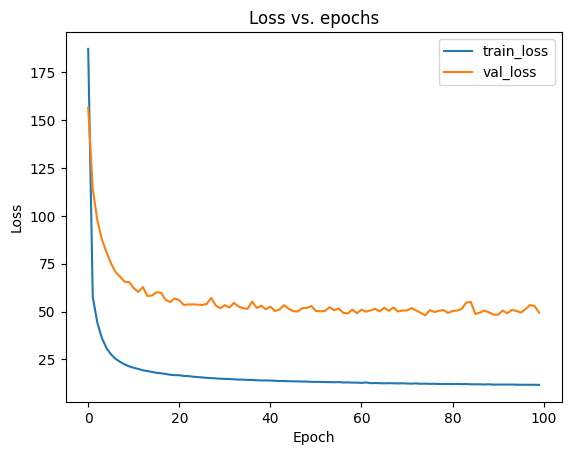

In [12]:

# test_loss, test_mae = model.evaluate(x_test, y_test)

# Plot the graph of the loss after nine epochs
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()



In [13]:
predicted_weights = np.squeeze(model.predict(x_test))
true_weights = y_test

277/277 [==============================] - 3s 7ms/step


In [15]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [16]:
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
print('METRICS ON ENTIRE DATASET:')
print('--------------------------')
# rmse = np.sqrt(cnn.evaluate(test_images, verbose=0))
rmse = mean_squared_error(true_weights, predicted_weights)**0.5
print("Test RMSE:\t{:.5f}".format(rmse))
r2 = r2_score(true_weights,predicted_weights)
print("Test R^2 Score:\t{:.5f}".format(r2))
MAPE = mape(true_weights, predicted_weights)
print("Test MAPE:\t{:.5f}%".format(MAPE))
print('--------------------------')

METRICS ON ENTIRE DATASET:
--------------------------
Test RMSE:	4.81642
Test R^2 Score:	0.79400
Test MAPE:	4.79075%
--------------------------
